### Import knihoven a konfigurace

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display

from scipy.spatial import distance

%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Pomocné funkce

In [2]:
%run ../svz.ipynb

### První část - rovnání dokumentu a následná aplikace OCR
Práce probíhá se souborem `ocr_img.jpg` na kterém se nachází dokument známých rozměrů (papír A4). Dokument je potřeba transformovat na kolmý pohled a následně využít Google Cloud Vision API k automatizovanému přečtení textu pomocí OCR. Za tuto část je možné získat maximálně **3 body**.

![](ocr_img.jpg)

**1) Načtěte obrázek, zobrazte ho a uložte si pole cílových korespondečních souřadnic rohů dokumentu.**

In [3]:
image = cv2.imread('./ocr_img.jpg')
# corners of the real A4 paper
real_world_pts = np.array([(0, 2100), (0, 0), (2970, 0), (2970, 2100)])

**2) Pomocí již hotové funkce `select_image_points()` vyberte obrazové souřadnice rohů dokumentu.**  
Souřadnice musí korespondovat pořadím, takže pokud je levý roh první v předchozím poli, musí být první vybrán i v tomto kroku.

In [4]:
# select_image_points(image)
# [(731, 1121), (149, 560), (974, 120), (1555, 453)]

In [5]:
image_pts = np.array([(731, 1121), (149, 560), (974, 120), (1555, 453)])

if (len(image_pts) != len(real_world_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

format: x, y 
 [[ 731 1121]
 [ 149  560]
 [ 974  120]
 [1555  453]]


**3) Vypočtěte transformační matici H, vypište její tvar.**

In [6]:
H, mask = cv2.findHomography(image_pts, real_world_pts)
print(H)

[[2.430 -2.521 1049.632]
 [2.162 4.054 -2592.613]
 [-0.000 0.001 1.000]]


**4) Popište rozdíl mezi [`cv2.getPerspectiveTransform()`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#ga8c1ae0e3589a9d77fffc962c49b22043) a [`cv2.findHomography`](https://docs.opencv.org/3.4.1/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780).**

Obě počítají matici pro odstranění perspektivní transformace.

[`cv2.getPerspectiveTransform()`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#ga8c1ae0e3589a9d77fffc962c49b22043) vyžaduje na vstupu právě 4 odpovídající dvojice bodů (zdrojových a cílových - v našem případě rohy A4 papíru na obrázku a rohy skutečné A4), přičemž vyžaduje **naprostou přesnost** těchto bodů, kterou při našem manuálním vybírání nemůžeme zaručit. 
[`cv2.findHomography`](https://docs.opencv.org/3.4.1/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) můžeme předat více než 4 dvojice zdrojových a cílových bodů, ale hlavně nevyžaduje takovou přenost bodů, což se nám hodí.

zdroj: https://stackoverflow.com/questions/11237948/findhomography-getperspectivetransform-getaffinetransform

**5) Využijte funkci [`cv2.warpPerspective`](https://docs.opencv.org/3.4.1/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) k vytvoření kolmého pohledu dokumentu, výsledek zobrazte a uložte.**

True

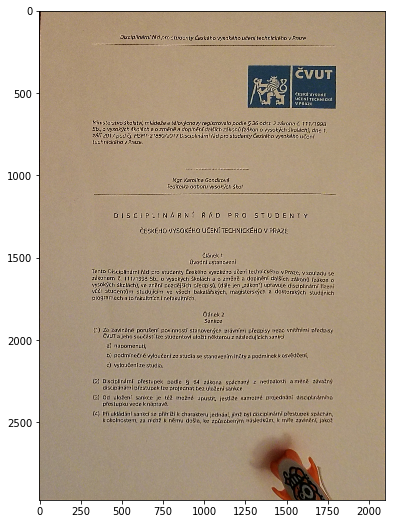

In [8]:
warped_img = cv2.warpPerspective(image, H, (2970, 2100))
warped_img = rotate(warped_img, -90) 
plot_images(warped_img)
cv2.imwrite('./warped_img.jpg', warped_img)

**6) Zprovozněte si účet na Google Cloudu, abyste mohli využívat službu Cloud Vision API.**

K aktivaci využijte fakultní emailový účet a odkaz, který jsem vám zaslal emailem. Službu Vision je pak nutné explicitně aktivovat v nastavení a ve svém lokálním Python prostředí doinstalovat některé závislosti pomocí příkazu `pip install`. Posledním krokem je vytvoření přístupových údaju v Google Cloudu a stažení API klíče (idealně ve formátu JSON). Blizší detaily o zprovoznění naleznete na https://cloud.google.com/vision/docs/.

**7) Detekujte text na "narovnaném" obraze pomocí níže uvedené funkce, text vypiště a uložte do textového souboru.** 

In [12]:
def ocr_google(img_path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    import os
    
    api_key = 'api-key.json'
    assert os.path.exists(api_key), 'There is no API-KEY in your path! You need to contact google to get one.'
    client = vision.ImageAnnotatorClient.from_service_account_json(api_key)
    
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    annotations = response.text_annotations

    return annotations

In [13]:
texts = ocr_google('./warped_img.jpg')

In [14]:
print(texts[0].description)
# source: https://cloud.google.com/vision/docs/detecting-text#vision-text-detection-python

with open('output.txt', 'w', encoding='utf-8') as output_file:
    output_file.write(texts[0].description)

Disciplinární řád pro studenty Českého vysokého učení technického v Praze
ČVUT
CESKE VYSoxt
UCENITECHNICKE
V PRAZE
Ministerstvo školství, mládeže a tělovýchovy registrovalo podle § 36 odst. 2 zákona 11 1/1998
Sb, o vysokých školách a o změně a doplnění dalších zákonů (zákon o vysokých školách), dne 1
záři 2017 pod čj. MSMT-21850/2017 Disciplinární řád pro studenty Ceského vysokého učení
technického v Praze
Mgr. Karolina Gondková
ředitelka odboru vysokých škoł
DIS CIPLINARNI RAD PRO STUDENTY
ČESKÉHO VYSOKÉHO UCENI TECHNICKEHO V PRAZE
čianek 1
Üvodní ustanoveni
Tento Disciplinární řád pro studenty Českého vysokého učení technického v Praze, v souladu se
zákonem č 111/1998 Sb, o vysokých školách a o změně a dopinění dalších zákonů (zákon o
vysokých školách), ve znění pozdějších předpisů, (dále jen ,zákon) upravuje disciplinární tizení
vůči studentum studujícím ve všech bakalářských, magisterských a doktorských studijních
programech a to fakultních i nefakultních.
čiánek 2
Sankce
(1) za za

### Druhá část - výtvarné umění na FITu
Práce probíhá s fotografií `fit_budova.jpg` od autora Tomáše Kouby a s malbou `fit_logo.jpg` od autora Lukáš Brchla. Cílem je umístit obrázek loga na stěnu budovy FITu viz obrázek. Za tuto část je možné získat maximálně **3 body**.

**1) Načtěte obrázky a vytvořte pole korespondečních souřadnic rohů malby.**

In [9]:
main_img = cv2.imread('./fit_budova.jpg')
logo_img = cv2.imread('./fit_logo.jpg')

logo_pts = np.array([(0, 719), (0, 0), (141, 0), (141, 719)])

**2) Vyberte souřadnice v obraze, do kterých má být logo transformováno (pozor na pořadí).**

In [10]:
# select_image_points(main_img)
# [(69, 416), (190, 26), (250, 65), (171, 412)]

In [11]:
image_pts = np.array([(69, 416), (189, 25), (251, 66), (171, 412)])
if (len(image_pts) != len(logo_pts)):
    raise ValueError('Real world points and image points must be the same size.')

print('format: x, y \n', image_pts)

format: x, y 
 [[ 69 416]
 [189  25]
 [251  66]
 [171 412]]


**3) Vypočtěte transformační matici H, vypište její tvar.**

In [12]:
H, mask = cv2.findHomography(logo_pts, image_pts)
print(H)

[[0.665 -0.195 189.000]
 [0.350 0.374 25.000]
 [0.001 -0.000 1.000]]


**4) Využijte funkci `cv2.warpPerspective()` k vytvoření stejné perspektivy loga jako fotografie budovy. Zobrazte výsledky.**

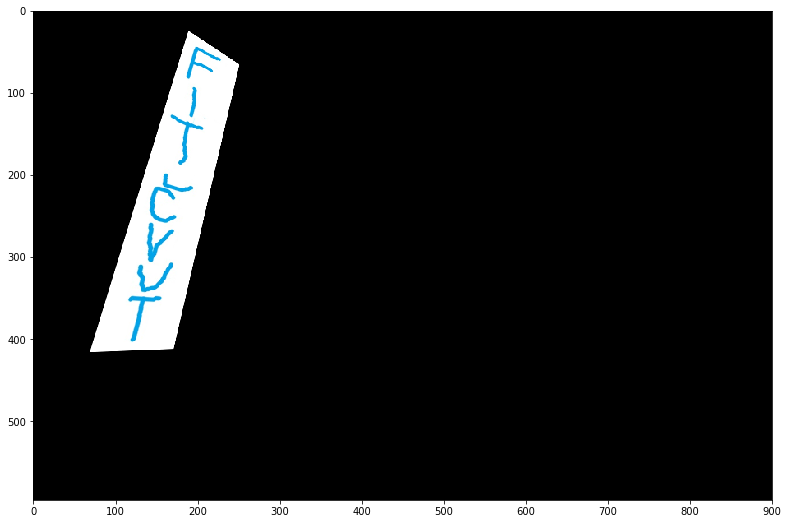

In [13]:
# we want the logo image to have the same size as main image 
height, width, channels = main_img.shape
dsize = (width, height)
warped_logo_img = cv2.warpPerspective(logo_img, H, dsize)
plot_images(warped_logo_img)

**5) Logo je nutné umístit na budovu bez bílého pozadí, je tedy nutné ho segmentovat.**

#Tady se mohou vaše postupy lišit. Kvalita segmentace následně razantně rozhoduje o kvalitě výsledku. Zkuste experimentovat s různými druhy segmentace a zkuste využít i nějaké funkce pro předzpracování, jako např. rozmazání. Může se vám hodit funkce `cv2.bitwise_and`.

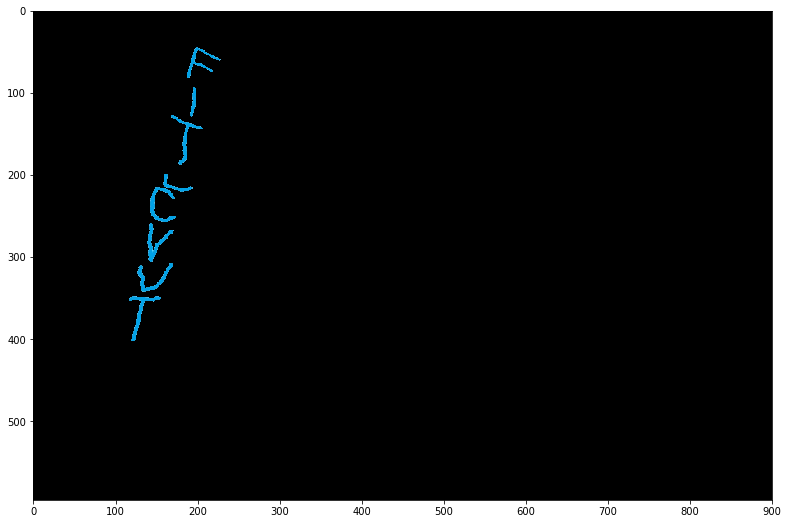

In [14]:
# Approach 1) - use segmentation with two thresholds on BGR image

ksize = 1 # this worked the best (no blur)
logo_blur = cv2.medianBlur(warped_logo_img, ksize)

logo_lower_bound = (0, 120, 0)
logo_upper_bound = (255, 230, 90)
logo_mask = segmentation_two_thresholds(logo_blur, logo_lower_bound, logo_upper_bound)

logo_nobgr1 = cv2.bitwise_and(warped_logo_img, warped_logo_img, mask=logo_mask)

plot_images(logo_nobgr1)

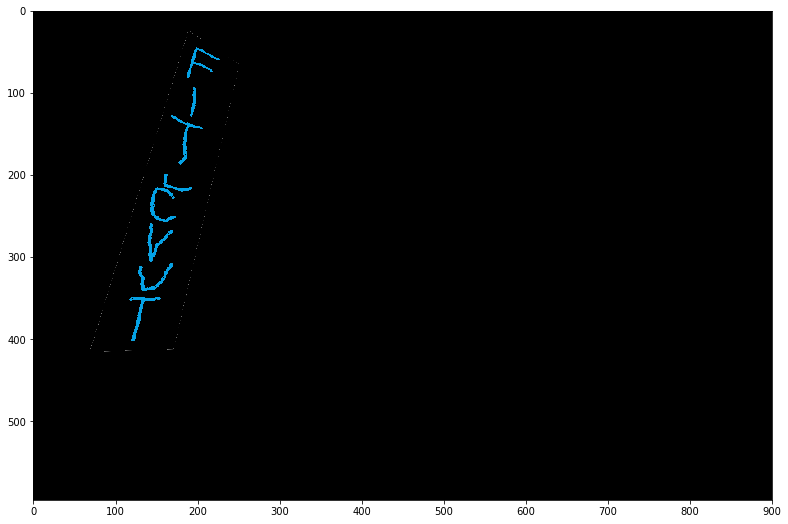

In [15]:
# Approach 2) - use segmentation with auto threshold on gray image

logo_gray = to_gray(warped_logo_img)
# get negative image, so that the segmentation gives us the logo and not the background 
logo_gray_neg = negative(logo_gray)

ksize = 1 # this worked the best (no blur)
logo_blur = cv2.medianBlur(logo_gray_neg, ksize)

logo_mask = segmentation_auto_threshold(logo_blur)

logo_nobgr2 = cv2.bitwise_and(warped_logo_img, warped_logo_img, mask=logo_mask)
plot_images(logo_nobgr2)

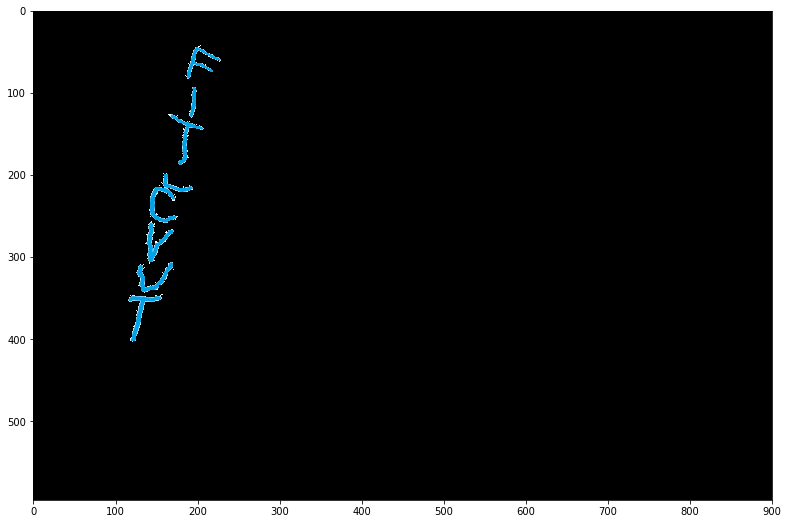

In [17]:
# Approach 3) - use segmentation with two thresholds on HSV image

logo_hsv = to_hsv(warped_logo_img)

ksize = 1 # this worked the best
logo_blur = cv2.medianBlur(logo_hsv[:, :, 0], ksize) 

logo_mask = segmentation_two_thresholds(logo_blur, to_intensity(190), to_intensity(210))
# a lot of noise in there, so I used contours to get only the letters
logo_con, _, _ = contours(logo_mask, 50)

logo_nobgr3 = cv2.bitwise_and(warped_logo_img, warped_logo_img, mask=logo_con)

plot_images(logo_nobgr3)

Přístup 1 poskytl nejlepší (a podle mě i docela uspokojivý) výsledek. 

**6) Spojte zdrojovou fotografii budovy se segmentovaným logem. Výsledek zobrazte a uložte.**

Nejedná se o žádnou složitou operaci, existuje na to přímo OpenCV funkce.

True

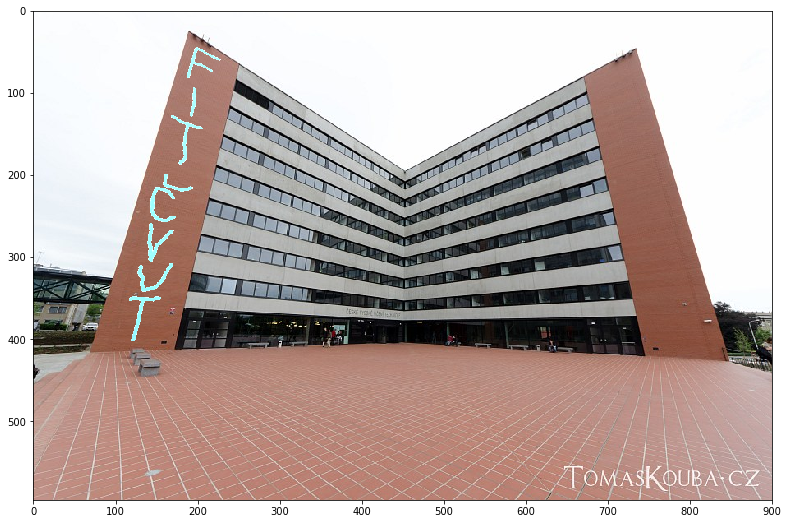

In [18]:
merged_img = cv2.add(main_img, logo_nobgr1)
plot_images(merged_img)
cv2.imwrite('./merged_img.jpg', merged_img)